<a href="https://colab.research.google.com/github/eriknorlander/portfolio/blob/main/S%26P_500_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance

In [ ]:
import yfinance as yf
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 

In [ ]:
from google.colab import drive
if 'google.colab' in str(get_ipython()):
    drive.mount('/content/drive')
    PATH = '/content/drive/MyDrive/portfolio/data/'
    DATA_PATH = PATH + 'sp500/'
    print('Running on CoLab')
else:
    PATH = '/Users/eriknorlander/portfolio/data/sp500/'
    print('Not running on CoLab')

Mounted at /content/drive
Running on CoLab


In [ ]:
sp500 = pd.read_csv(PATH + 'sp500.csv')
tickers = sp500.Symbol.tolist()
print(tickers[:5])

['MMM', 'AOS', 'ABT', 'ABBV', 'ABMD']


## Get Stock Data and write to csv

In [ ]:
from os import listdir
tickers_in_directory = [filename.replace('.csv','') for filename in listdir(DATA_PATH)]
print('Length :', len(tickers_in_directory), 'First 5 :', tickers_in_directory[:5])

Length : 507 First 5 : ['NOC (1)', 'SP500_Close', 'MMM', 'ABT', 'ABBV']


In [ ]:
from tqdm import tqdm
for ticker in tqdm(tickers):
    if ticker not in tickers_in_directory:
        try:
            stock = yf.Ticker(ticker)
            history = stock.history(period='5y')
            history.to_csv(DATA_PATH + str(ticker) + ".csv")
        except Exception as ex:
            print('Could not get f{ticker} : ' + ex)


100%|██████████| 505/505 [00:00<00:00, 81388.03it/s]


In [ ]:
def get_stock_from_csv(filepath, ticker):
    df = pd.read_csv(str(filepath) + str(ticker) + '.csv')
    df = df.set_index('Date', drop=True)
    if 'Unnamed: 0' in df.columns:
        df = df.drop('Unnamed: 0', axis=1)
    return df

## Compute statistics

In [ ]:
def add_daily_return(df):
    df['Daily Return'] = (df['Close'] / df['Close'].shift(1)) - 1
    return df  

def add_cum_return(df):
    df['Cum Return'] = (1 + df['Daily Return']).cumprod()
    return df

def add_bollinger_bands(df):
    df['Middle Band'] = df['Close'].rolling(window=20).mean()
    df['Upper Band'] = df['Middle Band'] + 1.96 * df['Close'].rolling(window=20).std()
    df['Lower Band'] = df['Middle Band'] - 1.96 * df['Close'].rolling(window=20).std()
    return df

def add_ichimoku(df):
    # Conversion
    hi_val = df['High'].rolling(window=9).max()
    low_val = df['Low'].rolling(window=9).min()
    df['Conversion'] = (hi_val + low_val) / 2

    # Baseline
    hi_val2 = df['High'].rolling(window=26).max()
    low_val2 = df['Low'].rolling(window=26).min()
    df['Baseline'] = (hi_val2 + low_val2) / 2

    # Spans
    df['SpanA'] = ((df['Conversion'] + df['Baseline']) / 2).shift(26)
    hi_val3 = df['High'].rolling(window=52).max()
    low_val3 = df['Low'].rolling(window=52).min()
    df['SpanB'] = ((hi_val3 + low_val3) / 2).shift(26)
    df['Lagging'] = df['Close'].shift(-26)

    return df

In [ ]:
for ticker in tqdm(tickers):
    try:
        new_df = get_stock_from_csv(DATA_PATH, ticker)
        new_df = add_daily_return(new_df)
        new_df = add_cum_return(new_df)
        new_df = add_bollinger_bands(new_df)
        new_df = add_ichimoku(new_df)
        new_df.to_csv(DATA_PATH + ticker + '.csv')
    except Exception as ex:
        print('Could not compute for : ' + str(ticker) + ' ' + ex)

100%|██████████| 505/505 [00:38<00:00, 13.04it/s]


In [ ]:
df = get_stock_from_csv(DATA_PATH, 'AMD')

In [ ]:
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Daily Return,Cum Return,Middle Band,Upper Band,Lower Band,Conversion,Baseline,SpanA,SpanB,Lagging
Date,,,,,,,,,,,,,,,,,
2017-01-24,9.950000,10.490000,9.950000,10.440000,43991200,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.90
2017-01-25,10.740000,10.980000,10.150000,10.350000,61778100,0,0,-0.008621,0.991379,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.03
2017-01-26,10.350000,10.660000,10.300000,10.520000,35866600,0,0,0.016425,1.007663,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.04
2017-01-27,10.600000,10.730000,10.520000,10.670000,32719200,0,0,0.014259,1.022031,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.05
2017-01-30,10.620000,10.680000,10.300000,10.610000,37725000,0,0,-0.005623,1.016284,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-18,134.500000,136.389999,131.589996,131.929993,56527400,0,0,-0.036163,12.636973,141.112999,155.156394,127.069604,134.394997,140.879997,147.477503,132.135002,NaN
2022-01-19,133.550003,134.570007,128.020004,128.270004,69831800,0,0,-0.027742,12.286399,140.736499,155.712679,125.760319,133.139999,140.879997,148.472504,132.135002,NaN
2022-01-20,126.040001,128.509995,121.410004,121.889999,91157300,0,0,-0.049739,11.675288,139.618499,156.605299,122.631699,131.330002,139.070000,148.045002,132.140003,NaN


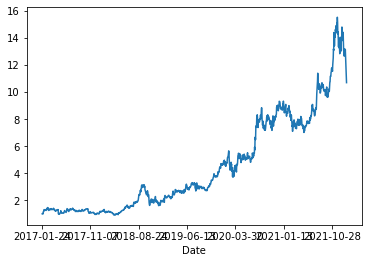

In [ ]:
df['Cum Return'].plot()

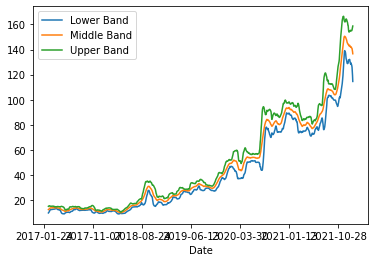

In [ ]:
df[['Lower Band', 'Middle Band', 'Upper Band']].plot()

## Grouping by sector

In [ ]:
sp500

,Symbol,Name,Sector
0,MMM,3M,Industrials
1,AOS,A. O. Smith,Industrials
2,ABT,Abbott Laboratories,Health Care
3,ABBV,AbbVie,Health Care
4,ABMD,Abiomed,Health Care
...,...,...,...
500,YUM,Yum! Brands,Consumer Discretionary
501,ZBRA,Zebra Technologies,Information Technology
502,ZBH,Zimmer Biomet,Health Care
503,ZION,Zions Bancorp,Financials


In [ ]:
def get_stock_cum_ret(data_path, tickers):
    cum_rets = []
    index = []
    for ticker in tqdm(tickers):
        try:
            df = get_stock_from_csv(data_path, ticker)
            cum = df['Cum Return'].iloc[-1]
            cum_rets.append(cum)
            index.append(ticker)
        except Exception as ex:
            print("Can't compute : {}".format(ticker) + ' ' + str(ex))
    return pd.DataFrame({'Ticker' : index, 'Cum Returns' : cum_rets})

In [ ]:
df_cum = get_stock_cum_ret(DATA_PATH, tickers)
df_cum = sp500.merge(df_cum, left_on='Symbol', right_on='Ticker', how='inner')

 14%|█▍        | 72/505 [00:08<00:09, 45.40it/s]

Can't compute : BRK.B single positional indexer is out-of-bounds


 17%|█▋        | 86/505 [00:08<00:08, 48.35it/s]

Can't compute : BF.B single positional indexer is out-of-bounds


100%|██████████| 505/505 [00:15<00:00, 32.95it/s]


In [ ]:
df_cum.head()

,Symbol,Name,Sector,Ticker,Cum Returns
0,MMM,3M,Industrials,MMM,1.124286
1,AOS,A. O. Smith,Industrials,AOS,1.707232
2,ABT,Abbott Laboratories,Health Care,ABT,3.294356
3,ABBV,AbbVie,Health Care,ABBV,2.691106
4,ABMD,Abiomed,Health Care,ABMD,2.720614


In [ ]:
def find_best(df, col, number):
    sub_df = df[['Ticker', col]].set_index('Ticker', drop=True)
    return sub_df[col].sort_values(ascending=False).head(number)

In [ ]:
df_sector = df_cum.groupby('Sector').apply(lambda x : find_best(x, 'Cum Returns', 2))

In [ ]:
tickers_to_buy = [k[1] for k, _ in df_sector.to_dict().items()]

In [ ]:
tickers_to_buy

['MTCH',
 'LYV',
 'TSLA',
 'ETSY',
 'EL',
 'COST',
 'COP',
 'MPC',
 'MSCI',
 'SPGI',
 'MRNA',
 'DXCM',
 'GNRC',
 'ODFL',
 'ENPH',
 'AMD',
 'SHW',
 'AVY',
 'PLD',
 'CBRE',
 'NEE',
 'NRG']

## Portfolio Selection

In [ ]:
def get_stocks_by_column(data_path, tickers, column, start_date, end_date):
    output_df = pd.DataFrame()
    for ticker in tqdm(tickers):
        try:
            df = get_stock_from_csv(data_path, ticker)
            mask = (df.index >= start_date) & (df.index <= end_date)
            output_df[ticker] = df.loc[mask][column]
        except Exception as ex:
            print("Can't compute : {}".format(ticker) + ' ' + str(ex))
    return output_df

In [ ]:
portfolio = get_stocks_by_column(data_path=DATA_PATH, tickers=tickers_to_buy, column='Close', start_date='2017-01-01', end_date='2022-01-25')

100%|██████████| 22/22 [00:00<00:00, 56.67it/s]


In [ ]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1260 entries, 2017-01-24 to 2022-01-24
Data columns (total 22 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   MTCH    1260 non-null   float64
 1   LYV     1260 non-null   float64
 2   TSLA    1260 non-null   float64
 3   ETSY    1260 non-null   float64
 4   EL      1260 non-null   float64
 5   COST    1260 non-null   float64
 6   COP     1260 non-null   float64
 7   MPC     1260 non-null   float64
 8   MSCI    1260 non-null   float64
 9   SPGI    1260 non-null   float64
 10  MRNA    788 non-null    float64
 11  DXCM    1260 non-null   float64
 12  GNRC    1260 non-null   float64
 13  ODFL    1260 non-null   float64
 14  ENPH    1260 non-null   float64
 15  AMD     1260 non-null   float64
 16  SHW     1260 non-null   float64
 17  AVY     1260 non-null   float64
 18  PLD     1260 non-null   float64
 19  CBRE    1260 non-null   float64
 20  NEE     1260 non-null   float64
 21  NRG     1260 non-null   flo

### Compute returns of portfolio

In [ ]:
def compute_log_returns(portfolio):
    return np.log(portfolio / portfolio.shift(1))

In [ ]:
portfolio = portfolio.dropna()
returns = compute_log_returns(portfolio)

### Select only non-correlated stocks
In order for Harry Markowitz portfolio optimization to work we need non-correlated stocks!

In [ ]:
def drop_colinear(returns):
    corr_matrix = returns.corr()

    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

    # Find features with correlation greater than 0.5
    to_drop = [column for column in upper.columns if any(upper[column] > 0.50)]

    return returns.drop(to_drop, axis=1)

In [ ]:
returns = drop_colinear(returns)

In [ ]:
returns

,MTCH,LYV,TSLA,ETSY,EL,COST,MSCI,MRNA,GNRC,ENPH
Date,,,,,,,,,,
2018-12-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-12-10,0.006002,-0.014071,0.019859,0.025995,0.006253,-0.009832,0.002734,0.010695,0.003232,0.000000
2018-12-11,0.002490,-0.003318,0.004399,-0.001085,0.008156,0.017099,0.012179,-0.042930,-0.022067,0.003515
2018-12-12,0.060317,0.009738,-0.000436,0.038156,-0.002736,0.005723,0.012358,0.036526,0.031512,0.017392
2018-12-13,-0.013198,-0.001281,0.027417,-0.042325,0.010041,-0.005679,-0.006977,0.004274,0.006185,-0.006920
...,...,...,...,...,...,...,...,...,...,...
2022-01-18,-0.044561,0.003478,-0.018365,-0.001284,-0.035075,-0.030111,-0.019264,-0.092671,-0.037863,-0.049659
2022-01-19,0.003446,-0.016894,-0.034413,-0.002143,-0.004609,0.004273,-0.006388,-0.069563,-0.012077,-0.009908
2022-01-20,0.020347,-0.007443,0.000623,-0.023882,-0.027713,-0.015088,0.004761,-0.038355,-0.025198,0.000817


In [ ]:
import seaborn as sns 
def heatmap(returns):
    fig = plt.figure(figsize=(16,10))
    corr_matrix = returns.corr()
    sns.heatmap(corr_matrix, annot=True)
    plt.show()
    return corr_matrix

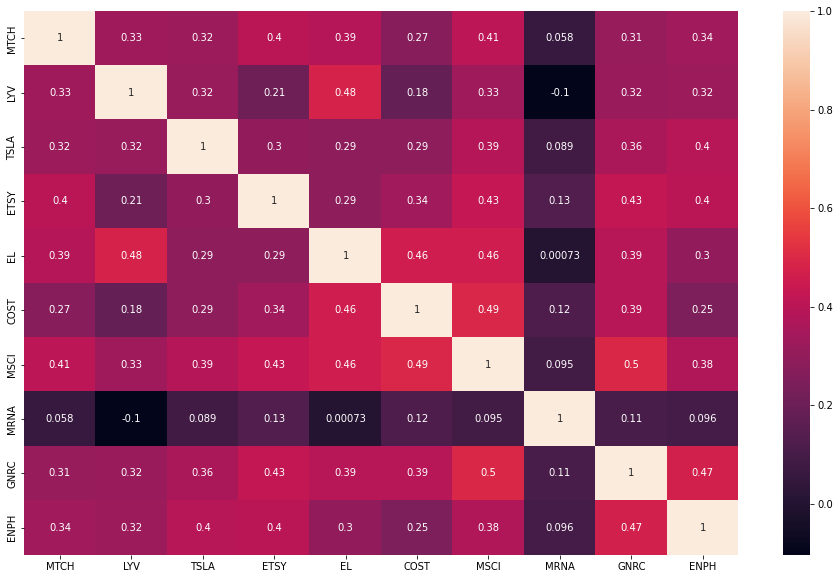

In [ ]:
corr_matrix = heatmap(returns)

## Portfolio optimization
We will start by computing mean returns of the portfolio:

The crucial part is the constant 252 which corresponds to the yearly average of 252 trading days.

In [ ]:
tickers_in_portfolio = list(returns.columns)
num_stocks = len(tickers_in_portfolio)

In [ ]:
def compute_mean_returns(returns):
    mean_ret = returns.mean() * 252 # 252 average trading days per year
    return mean_ret.sort_values(ascending=False)

In [ ]:
print(compute_mean_returns(returns))

ENPH    0.974167
TSLA    0.805175
MRNA    0.658795
GNRC    0.530947
MSCI    0.387208
MTCH    0.330742
ETSY    0.327696
COST    0.256647
EL      0.249407
LYV     0.204608
dtype: float64


### Random initialization of weights
And now we create a random initialization for the weights

In [ ]:
def generate_random_weights(num_stocks):
    # Generate 11 random values that sum to 1
    weights = np.random.random(num_stocks)
    weights /= np.sum(weights)
    return weights

In [ ]:
weights = generate_random_weights(num_stocks)

### Compute returns with weights

In [ ]:


def compute_returns(returns, weights):
    return np.sum(weights * returns.mean()) * 252

In [ ]:


compute_returns(returns, weights)

0.44541298194144

Pretty good for random weights!

### Compute volatility
Volatility of portfolio is really the standard deviation. It is computed as the sum of the variance and covariance of all assets multiplied by weight. Again, multiplied with 252 for the average yearly trading days. We do it explicitly here in order to show how to compute it.

$ \sigma = \sqrt{w^T \Sigma w} $

$w$ = weight vector

$\Sigma$ = Covariance matrix

In [ ]:
def compute_volatility(returns, weights):
    return np.sqrt(np.dot(weights.T, np.dot(returns.cov()*252, weights)))

### Sharpe Ratio
People want to maximize returns while avoiding as much risk as possible. William Sharpe created the Sharpe Ratio to find the portfolio that provides the best return for the lowest amount of risk.


$SR = \frac{r_i - r_f}{\sigma_i}$

$r_f$ = Risk free rate

$r_i$ = Rate of returns of the stc

$\sigma_i$ = Standard Deviation of the Stock

In [ ]:
def compute_sharpe_ratio(sum_returns, volatility, risk_free_rate):
    return (sum_returns - risk_free_rate) / volatility

# Monte Carlo simulation

In [ ]:
p_ret = [] # Returns list
p_vol = [] # Volatility list
p_SR = [] # Sharpe Ratio list
p_wt = [] # Stock weights list
risk_free_rate = 0.0125 


for x in tqdm(range(10000)):
    # Generate random weights
    p_weights = generate_random_weights(num_stocks)
    
    # Add return using those weights to list
    ret_1 = compute_returns(returns, p_weights)
    p_ret.append(ret_1)
    
    # Add volatility or standard deviation to list
    vol_1 = compute_volatility(returns, p_weights)
    p_vol.append(vol_1)
    
    # Get Sharpe ratio
    SR_1 = compute_sharpe_ratio(ret_1, vol_1, risk_free_rate)
    p_SR.append(SR_1)
    
    # Store the weights for each portfolio
    p_wt.append(p_weights)
    
# Convert to Numpy arrays
p_ret = np.array(p_ret)
p_vol = np.array(p_vol)
p_SR = np.array(p_SR)
p_wt = np.array(p_wt)

100%|██████████| 10000/10000 [00:13<00:00, 720.00it/s]


In [ ]:
SR_idx = np.argmax(p_SR)
SR_ideal = p_SR[SR_idx]
w_ideal = p_wt[SR_idx]
ret_ideal = p_ret[SR_idx]
vol_ideal = p_vol[SR_idx]

## Plotting the Efficient Frontier

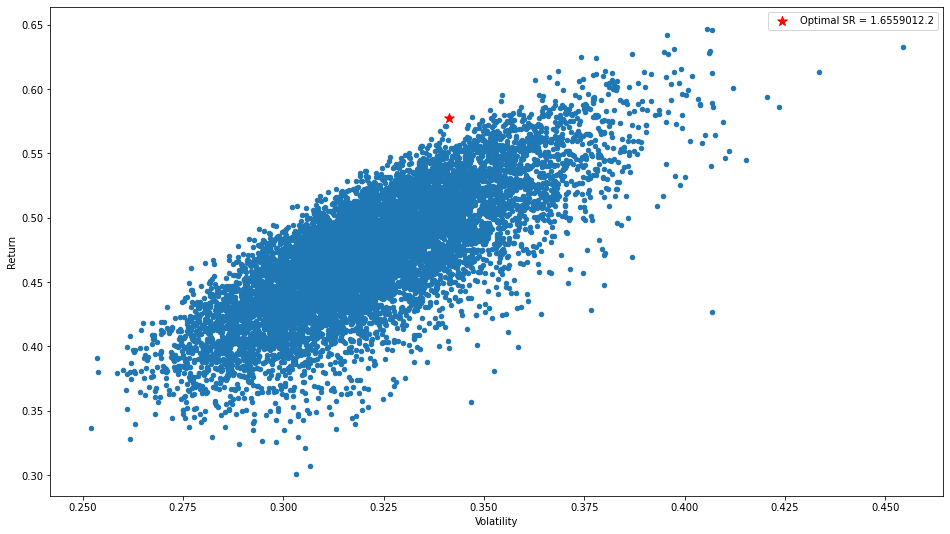

In [ ]:
# Create a dataframe with returns and volatility
ports = pd.DataFrame({'Return': p_ret, 'Volatility': p_vol})

ports.plot(x='Volatility', y='Return', kind='scatter', figsize=(16, 9))

plt.scatter(vol_ideal, ret_ideal, c='r', marker='*', s=100,
            label='Optimal SR = %f2.2' % (SR_ideal))
plt.legend()
plt.show()

In [ ]:
# Return the index of the largest Sharpe Ratio

# Find the ideal portfolio weighting at that index
i = 0
print('Ideal weighting of portfolio')
while i < num_stocks:
    ticker = tickers_in_portfolio[i]
    if len(ticker) == 4:
        print("%s : %2.2f" % (ticker, w_ideal[i]))
    elif len(ticker) == 3:
        print("%s  : %2.2f" % (ticker, w_ideal[i]))
    elif len(ticker) == 2:
        print("%s   : %2.2f" % (ticker, w_ideal[i]))
    else:
        print("%s    : %2.2f" % (ticker, w_ideal[i]))
    i += 1
    
print("\nVolatility   : %f" % (vol_ideal) )  
print("Return       : %f" % (ret_ideal) )
print('Sharpe Ratio : %f' % (SR_ideal) )

Ideal weighting of portfolio
MTCH : 0.06
LYV  : 0.02
TSLA : 0.21
ETSY : 0.00
EL   : 0.02
COST : 0.16
MSCI : 0.07
MRNA : 0.19
GNRC : 0.17
ENPH : 0.10

Volatility   : 0.341183
Return       : 0.577465
Sharpe Ratio : 1.655901


# Classic optimization with Lagrangian Multipliers

We will be using JAX for efficient optimization.
Inspiration taken the following sources: 

1. [JAX-implementations of Lagrangian optimization](https://medium.com/swlh/solving-optimization-problems-with-jax-98376508bd4f)
2. [Lagrangians and Portfolio Optimization](https://www.adrian.idv.hk/2021-06-22-kkt/)

In [ ]:
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
from jax import jacfwd, jacrev
from jax.numpy import linalg
import matplotlib.pyplot as plt
from numpy import nanargmin,nanargmax 

key = random.PRNGKey(42)
print(jax.devices())

### Simple example

In [ ]:
y = lambda x : ((x * jnp.sqrt(12*x - 36)) / (2*(x-3)))
L = lambda x : jnp.sqrt(x**2 + y(x)**2)
gradL = grad(L)
minGD = lambda x : x - 0.01*gradL(x)

domain = jnp.linspace(3.0, 5.0, num=50)

solve = jit(vmap(minGD))

for epoch in tqdm(range(50)):
    domain = solve(domain)


100%|██████████| 50/50 [00:00<00:00, 398.38it/s]


In [ ]:
minfunc = vmap(L)
minimums = minfunc(domain)

In [ ]:
arglist = nanargmin(minimums)
argmin = domain[arglist]
minimum = minimums[arglist]
print('Min Val: %f x : %f' % (minimum, argmin) )

Min Val: 7.794247 x : 4.505732


### Multivariate Lagrangian Example with constraints

In this example, 

$\vec{x} = [x1, x2, \lambda]$ 

In [ ]:
f = lambda x : 4*(x[0]**2)*x[1]
g = lambda x : x[0]**2 + x[1]**2 - 3

Lagrange = lambda l : f(l[0:2]) - l[3]*g(l[0:2])
L = jacfwd(Lagrange)
gradL = jacfwd(L)

solve = lambda l : l - linalg.inv(gradL(l)) @ L(l)

domain = random.uniform(key, shape=(50, 3), dtype='float32', minval=-5.0, maxval=5.0)

solve = jit(vmap(solve))
for epoch in tqdm(range(50)):
    domain = solve(domain)


100%|██████████| 50/50 [00:01<00:00, 47.14it/s]


In [ ]:
minimums = vmap(f)(domain)      # get's values for each set of parameters
arglist = nanargmin(minimums)   # get's index of the minimum
argmin = domain[arglist]        # get's the set of parameters that minimize f
minimum = minimums[arglist]     # get's the minimum value
print("minimum of f(x) = {}, \nwith parameters x1 = {}, x2 = {}, lambda = {}".format(
    minimum, argmin[0], argmin[1], argmin[2]
))

minimum of f(x) = -7.999999523162842, 
with parameters x1 = -1.4142135381698608, x2 = -1.0, lambda = -4.0


### Optimize a portfolio with Lagrangian Mutlipliers

We want to optimize the weights $w = [w_1, w_2, w_3, ..., w_n]$ of a portfolio of $n$ assets such that:
1. we minimize volatility 
2. while maximizing returns
3. keeping the sum of weights equal to 1

We can express this as an optimization problem as:

$f(w) = \sqrt{w^T \Sigma w}$*

$h(w) = w^Tr - R$

$g(w) = w^TI - 1$

where, $\Sigma$ is the covariance matrix of past returns, $r = [r_1, r_2, ... r_n]$ are past mean returns of $n$ assets, $R = \sum_i^n r_i$ is the sum of said returns

In this case we need to satisfy 2 constraints, so we get the parametrs $[\lambda_1, \lambda_2]$ we have to deal with. The Lagrangian then becomes

$L(w, \lambda_1, \lambda_2) = f(w) - \lambda_1h(w) - \lambda_2g(w)$

For implementation purposes we keep all the parameters in $w, \lambda$ in a single vector $x = [w_1, w_2, w_3, ..., w_n, \lambda_1, \lambda_2]$.

In [ ]:
Sigma = jnp.array(returns.cov().to_numpy()*252)
r     = jnp.array(returns.mean().to_numpy()*252)
R     = jnp.sum(r)
n_l   = 2

w_domain = random.uniform(key, shape=(100,num_stocks), dtype='float32', minval=0, maxval=1)
norm = lambda x : x/jnp.sum(x)
w_domain = vmap(norm)(w_domain)
l_domain = random.uniform(key, shape=(100,n_l), dtype='float32', minval=0, maxval=4)
domain   = jnp.hstack([w_domain, l_domain])

In [ ]:
f = lambda w : jnp.sqrt(jnp.dot(w.T, jnp.dot(Sigma, w)))
g = lambda w : jnp.dot(w.T, r) - R 
h = lambda w : jnp.dot(w.T, jnp.ones(len(w))) - 1

Lagrange = lambda x : f(x[:-n_l]) - x[-2]*g(x[:-n_l]) - x[-1]*h(x[:-n_l])

jacoL = jacfwd(Lagrange)
hessL = jacfwd(jacoL)

solveL = lambda x : x - 0.001*linalg.inv(hessL(x)) @ jacoL(x)
solveL = jit(vmap(solveL))

In [ ]:
for epoch in tqdm(range(100)):
    domain = solveL(domain)

100%|██████████| 100/100 [00:04<00:00, 21.99it/s]


In [ ]:
minimums = vmap(f)(domain[:,:-n_l])       # get's values for each set of parameters
arglist = nanargmin(minimums)             # get's index of the minimum
argmin = domain[arglist]                  # get's the set of parameters that minimize f
minimum = minimums[arglist]               # get's the minimum value

In [ ]:
lambdas = argmin[-n_l:]
optimal_weights = argmin[:-n_l]
sum_returns = jnp.dot(optimal_weights, r)
volatility = jnp.sqrt(jnp.dot(optimal_weights.T, jnp.dot(Sigma, optimal_weights)))
sharpe_ratio = (sum_returns - risk_free_rate) / volatility

In [ ]:
lambdas

DeviceArray([2.2219822 , 0.56734186], dtype=float32)

In [ ]:
# Return the index of the largest Sharpe Ratio

# Find the ideal portfolio weighting at that index
i = 0
print('Ideal weighting of portfolio')
while i < num_stocks:
    ticker = tickers_in_portfolio[i]
    if len(ticker) == 4:
        print("%s : %2.2f"      % (ticker, weights[i]))
    elif len(ticker) == 3:
        print("%s  : %2.2f"     % (ticker, weights[i]))
    elif len(ticker) == 2:
        print("%s   : %2.2f"    % (ticker, weights[i]))
    else:
        print("%s    : %2.2f"   % (ticker, weights[i]))
    i += 1

print('\n')
print("Lambda_1     : %f" % (lambdas[0]))
print("Lambda_2     : %f" % (lambdas[1]))
    
print("\nVolatility   : %f" % (volatility) )  
print("Return       : %f" % (sum_returns) )
print("Sharpe Ratio : %f" % (sharpe_ratio) )

Ideal weighting of portfolio
MTCH : 0.11
LYV  : 0.11
TSLA : 0.02
ETSY : 0.18
EL   : 0.00
COST : 0.14
MSCI : 0.11
MRNA : 0.22
GNRC : 0.06
ENPH : 0.06


Lambda_1     : 2.221982
Lambda_2     : 0.567342

Volatility   : 0.527071
Return       : 0.848299
Sharpe Ratio : 1.585742


#### Conclusion
1. Rather dissapointing performance... High return but way too high volatility. If we let the optimization go it will not increase the Sharpe Ratio, but the Volatlity and Return will go up, which is a worse portfolio.
2. Very fast with jit! If anything, Jax is the big winner here.
3. Still requires a fair amount of tweaking.
4. Doesn't do anything for stock-picking which is still a manual process.

# Deep Learning approach

We want to create a model that, given input set of $n$ assets $X = \{x_1, x_2,..., x_n\}$ will generate a portfolio of weights $W = \{w_1, w_2, ..., w_n\} \in [0,1]$ and $\sum{W} = 1$ that minimizes volatility

$ \sigma = \sqrt{W^T \Sigma W} $

while it maximizes the Sharpe Ratio

$SR = \frac{r - r_f}{\sigma}$

$r_f$ = Risk free rate

$r$ = Rate of returns of the portfolio

$\sigma$ = Volatility of the portfolio


We therefore want to constuct a function $f$ that given input $X$ will produce our portfolio. This what we want to approximate with our neural net

$f(X) = w_1x_1 + w_2x_2 + ... + w_nx_n$

This is still an optimization problem and not really dealing with a $general$ model for portfolio optimization. More on that later... 

In [ ]:
!pip install flax

     |████████████████████████████████| 207 kB 5.4 MB/s 
     |████████████████████████████████| 126 kB 32.2 MB/s 
     |████████████████████████████████| 65 kB 2.6 MB/s 


## Imports

In [ ]:
import jax
import jax.numpy as jnp                # JAX NumPy

from flax import linen as nn           # The Linen API
from flax.training import train_state  # Useful dataclass to keep train state

import numpy as np                     # Ordinary NumPy
import optax                           # Optimizers
import tensorflow_datasets as tfds     # TFDS for MNIST
from ipywidgets import IntProgress
from tqdm import tqdm
from random import random

from os import listdir

## 1. Create a dataset 

In [ ]:
def get_stock_from_csv(filepath, ticker):
    df = pd.read_csv(str(filepath) + str(ticker) + '.csv')
    df = df.set_index('Date', drop=True)
    if 'Unnamed: 0' in df.columns:
        df = df.drop('Unnamed: 0', axis=1)
    return df

In [ ]:
tickers_in_directory = [filename.replace('.csv','') for filename in listdir(DATA_PATH)]

In [ ]:
def get_stocks_by_column(data_path, tickers, column, start_date, end_date):
    output_df = pd.DataFrame()
    for ticker in tqdm(tickers):
        try:
            df = get_stock_from_csv(data_path, ticker)
            mask = (df.index >= start_date) & (df.index <= end_date)
            output_df[ticker] = df.loc[mask][column]
        except Exception as ex:
            print("Can't compute : {}".format(ticker) + ' ' + str(ex))
    return output_df
    
def compute_log_returns(portfolio):
    return np.log(portfolio / portfolio.shift(1))

In [ ]:
df = get_stocks_by_column(data_path=DATA_PATH, 
                     tickers=tickers_in_directory,
                     column='Close',
                     start_date='2017-01-01',
                     end_date='2022-01-01')

100%|██████████| 506/506 [00:15<00:00, 32.30it/s]


In [ ]:
df.to_csv(DATA_PATH + 'SP500_Close.csv')

### 1.1 Load dataset 

In [ ]:
import random
def generate_random_portfolio(data, num_stocks=10, window=30):
    (length, assets) = data.shape
    stocks = random.sample(range(assets), num_stocks)
    data = data[:,stocks]
    iterations = int(np.floor(length/window))
    last_index = int(window*iterations)
    data = data[:last_index]
    data = data.reshape(iterations, num_stocks, window, 1)
    return data



In [ ]:
generate_random_portfolio()

506

AttributeError: ignored

In [ ]:
def generate_random_portfolio_index(key, total_number_stocks, portfolio_size):
    nbr_portfolios = int(total_number_stocks/portfolio_size)
    s = portfolio_size*nbr_portfolios
    rand_index = jax.random.choice(key=key, a=jnp.arange(total_number_stocks), 
                                  shape=(s,), replace=False)
    rand_index = rand_index.reshape(nbr_portfolios, portfolio_size)
    return rand_index

In [ ]:
key = jax.random.PRNGKey(1)
portfolio_size = 10
total_number_stocks = len(df.columns)

rand_index = generate_random_portfolio_index(key, total_number_stocks, portfolio_size)

In [ ]:
rand_index[0]

DeviceArray([306, 364, 359,  59, 144, 111, 367, 372, 376,  84], dtype=int32)

In [ ]:
complete_data.shape

(1244, 506)

In [ ]:
def generate_portfolio(data, column_index, window=30):
    (length, _) = data.shape
    num_stocks = len(column_index)
    data = data[:,column_index]
    iterations = int(np.floor(length/window))
    last_index = int(window*iterations)
    data = data[:last_index]
    data = data.reshape(iterations, num_stocks, window, 1)
    return data

In [ ]:
generate_portfolio(complete_data, rand_index[0], window=30).shape

(41, 10, 30, 1)

In [ ]:
def compute_log_returns(portfolio):
    return jnp.log(portfolio[1:]/ portfolio[:-1])


In [ ]:
complete_data = jnp.array(df.to_numpy(dtype='float32'))
complete_data = compute_log_returns(complete_data)

In [ ]:
data = generate_random_portfolio(complete_data)

In [ ]:
(iterations, assets, window, _) = data.shape

## 1. Creating the dataset

In [ ]:
data = jnp.array(returns.dropna().to_numpy())
(index, col) = data.shape
data = data.reshape(col, index, 1)

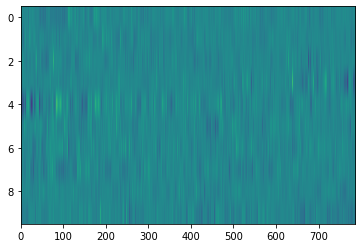

In [ ]:
to_show = data[:,:,0]
plt.imshow(to_show, aspect='auto')
plt.show()

## 2. Defining a model
We will treat every prospect portfolio as an image as seen above. I have a hunge that a Convolutional Neural Network will do fine on that task. This is the same model used in my Flax's MNIST-example. We will use that as a starting point.

In [ ]:
from typing import Sequence

class CNN(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Conv(features=32, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = nn.Conv(features=64, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = x.ravel() 
        x = nn.Dense(features=256)(x)
        x = nn.relu(x)
        x = nn.Dense(features=10)(x)
        x = nn.softmax(x)
        return x


## 3. Defining loss function

We want to directly optimize the Sharpe Ratio.

In [ ]:
def mean_returns(X, w):
    mean_returns = jnp.mean(X, axis=1)*252
    return jnp.dot(mean_returns.T, w)

def volatility(X, w):
    return jnp.sqrt(jnp.dot(w.T, jnp.dot(jnp.cov(X)*252, w)))

def sharpe_ratio(r, rf, v):
    return (r - rf) / v

def sharpe_loss(X, w, rf):
    (assets, window, _) = X.shape 
    X = X.reshape(assets, window)
    r = mean_returns(X, w)
    v = volatility(X,w)
    return - sharpe_ratio(r, rf, v), r, v

rf = 0.0125 
num_stocks=10
w = np.random.random(num_stocks)
w /= np.sum(w)
sample = data

(sl, r, v) = sharpe_loss(sample, w, rf)
sr = -sl

print('mean returns : ', r)
print('volatility   : ', v)
print('Sharpe Ratio : ', sr)
print('Sharpe Loss  : ', sl)

mean returns :  0.5562753
volatility   :  0.19108163
Sharpe Ratio :  2.845775
Sharpe Loss  :  -2.845775


## 4. Metric computation

In [ ]:
def compute_metrics(X, w, rf):
    (sl, r, v) = sharpe_loss(X, w, rf)
    metrics = {'mean returns' : r, 'volatility' : v,
               'sharpe ratio': -sl, 'loss' : sl}
    return metrics

## 5. Create Train State

In [ ]:
class CustomTrainState(train_state.TrainState):
    rf : int = 0.0125

def create_train_state(model, rng, learning_rate, momentum, sample, rf):
    params = model.init(rng, jnp.ones(np.shape([sample])))['params'] 
    tx = optax.sgd(learning_rate, momentum)
    return CustomTrainState.create(apply_fn=model.apply, params=params, tx=tx, rf=rf)

## 6 Initialize
This is simply for testing

In [ ]:
rng = jax.random.PRNGKey(0)
rng, init_rng = jax.random.split(rng)
lr = 0.01
m = 0.7
rf = 0.0125
model = CNN()
state = create_train_state(model, rng, lr, m, sample, rf)
print(jax.tree_map(jnp.shape, state.params))

FrozenDict({
    Conv_0: {
        bias: (32,),
        kernel: (3, 3, 1, 32),
    },
    Conv_1: {
        bias: (64,),
        kernel: (3, 3, 32, 64),
    },
    Dense_0: {
        bias: (256,),
        kernel: (25088, 256),
    },
    Dense_1: {
        bias: (10,),
        kernel: (256, 10),
    },
})


## 7. Predict and evaluate

In [ ]:
@jax.jit
def predict(state, X):
    return state.apply_fn({'params' : state.params}, X)

@jax.jit
def evaluate(state, X):
    w_pred = state.apply_fn({'params' : state.params}, X)
    return compute_metrics(X, w_pred, state.rf)

In [ ]:
w_pred = predict(state, sample)
print(evaluate(state, sample)['loss'])
X = sample

-2.6010003


## 8. Train Step

In [ ]:
@jax.jit
def train_step(state, X):
    def loss_fn(params):
        w_pred = state.apply_fn({'params' : params}, X)
        (loss, _, _) = sharpe_loss(X, w_pred, state.rf)
        return loss, w_pred
    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (_, w_pred), grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads) 
    metrics = compute_metrics(X, w_pred, state.rf)
    return state, metrics
#(_, w_pred), grads = grad_fn(state.params)

## 9. Training loop

In [ ]:
rng = jax.random.PRNGKey(0)
rng, init_rng = jax.random.split(rng)
lr = 0.01
m = 0.7
rf = 0.0125
model = CNN()
state = create_train_state(model, rng, lr, m, sample, rf)


epochs = 100
epoch_metrics = []
for epoch in range(1,epochs):
    state, metrics = train_step(state, sample)
    epoch_metrics.append(metrics)
    print('epoch : {} | loss : {:.5f} | returns : {:.5f} | vol : {:.5f} | sharpe ratio : {:.5f} |'.format(
      epoch, metrics['loss'], metrics['mean returns'], metrics['volatility'], metrics['sharpe ratio']))

epoch : 1 | loss : -2.60100 | returns : 0.47295 | vol : 0.17703 | sharpe ratio : 2.60100 |
epoch : 2 | loss : -2.63651 | returns : 0.47850 | vol : 0.17675 | sharpe ratio : 2.63651 |
epoch : 3 | loss : -2.68789 | returns : 0.48637 | vol : 0.17630 | sharpe ratio : 2.68789 |
epoch : 4 | loss : -2.75010 | returns : 0.49576 | vol : 0.17573 | sharpe ratio : 2.75010 |
epoch : 5 | loss : -2.83025 | returns : 0.50768 | vol : 0.17496 | sharpe ratio : 2.83025 |
epoch : 6 | loss : -2.93844 | returns : 0.52388 | vol : 0.17403 | sharpe ratio : 2.93844 |
epoch : 7 | loss : -3.08848 | returns : 0.54683 | vol : 0.17301 | sharpe ratio : 3.08848 |
epoch : 8 | loss : -3.29627 | returns : 0.58042 | vol : 0.17229 | sharpe ratio : 3.29627 |
epoch : 9 | loss : -3.56025 | returns : 0.62982 | vol : 0.17339 | sharpe ratio : 3.56025 |
epoch : 10 | loss : -3.81225 | returns : 0.69689 | vol : 0.17952 | sharpe ratio : 3.81225 |
epoch : 11 | loss : -3.94305 | returns : 0.76412 | vol : 0.19062 | sharpe ratio : 3.94305

Holy shit! now we're talking! 

## 10. Evaluation

In [ ]:
eval_df = pd.DataFrame(epoch_metrics,dtype='float32')

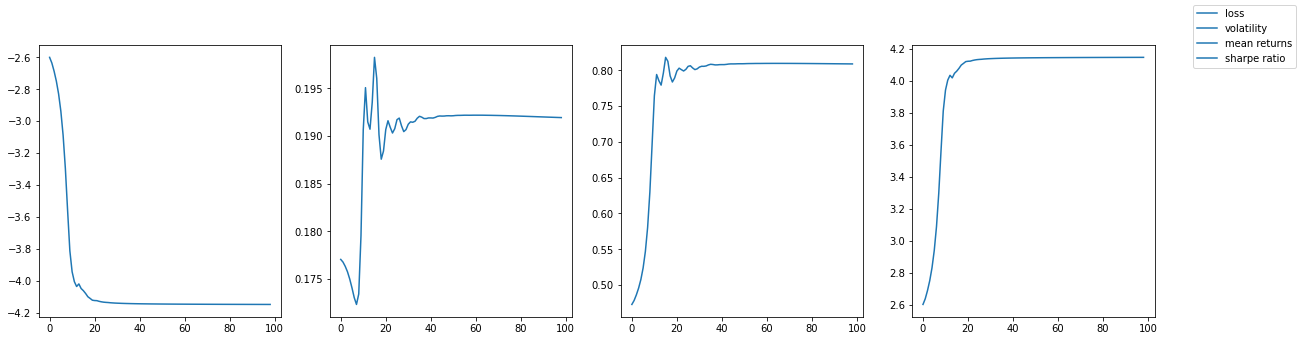

In [ ]:
fig, ax = plt.subplots(1,4,figsize=(20,5))
ax[0].plot(eval_df['loss'], label='loss')
ax[1].plot(eval_df['volatility'], label='volatility')
ax[2].plot(eval_df['mean returns'], label='mean returns')
ax[3].plot(eval_df['sharpe ratio'], label='sharpe ratio')
fig.legend()
plt.show()

In [ ]:
w_pred = predict(state, sample)

[1.91833854e-01 1.15749575e-01 1.50923301e-02 5.78107052e-02
 5.20337224e-02 1.49067968e-01 2.11723626e-01 6.07648573e-04
 2.05901474e-01 1.79103838e-04]


In [ ]:
# Return the index of the largest Sharpe Ratio

# Find the ideal portfolio weighting at that index
i = 0
print('Ideal weighting of portfolio')
while i < num_stocks:
    ticker = tickers_in_portfolio[i]
    if len(ticker) == 4:
        print("{} : {:.2f}".format(ticker, w_pred[i]))
    elif len(ticker) == 3:
        print("{}  : {:.2f}".format(ticker, w_pred[i]))
    elif len(ticker) == 2:
        print("{}   : {:.2f}".format(ticker, w_pred[i]))
    else:
        print("{}    : {:.2f}".format(ticker, w_pred[i]))
    i += 1

final_epoch = eval_df.tail(1)
vol = final_epoch['volatility'].values[0]
sharpe_ratio = final_epoch['sharpe ratio'].values[0]
returns = final_epoch['mean returns'].values[0]

print("\nVolatility   : {:.5f}".format(vol) )  
print("Return       : {:.5f}".format(returns) )
print("Sharpe Ratio : {:.5f}".format(sharpe_ratio) )

Ideal weighting of portfolio
MTCH : 0.19
LYV  : 0.12
TSLA : 0.02
ETSY : 0.06
EL   : 0.05
COST : 0.15
MSCI : 0.21
MRNA : 0.00
GNRC : 0.21
ENPH : 0.00

Volatility   : 0.19194
Return       : 0.80864
Sharpe Ratio : 4.14797


# Comparison

The results are in! What a fun journey we've had down Quant Lane! 

It turns out that optimizing the portfolio with a neural network gave us an absolutely amazing Sharp Ratio of 4.15! Although, Lagrange gave us higher returns, the neural net found a combination of stocks with way lower volatility. 

| Stock |Monte Carlo | Lagrange | Neural Net |
| --- | ----------- | ------- | ----|
|MTCH | 0.06 | 0.11 | 0.19 |
|LYV  | 0.02 | 0.11 | 0.12 |
|TSLA | 0.21 | 0.02 | 0.02 |
|ETSY | 0.00 | 0.18 | 0.06 |
|EL   | 0.02 | 0.00 | 0.05 |
|COST | 0.16 | 0.14 | 0.15 |
|MSCI | 0.07 | 0.11 | 0.21 |
|MRNA | 0.19 | 0.22 | 0.00 |
|GNRC | 0.17 | 0.06 | 0.21 |
|ENPH | 0.10 | 0.06 | 0.00 |
|-----|------|------|------|
|Vol  | 0.34 | 0.53 | 0.19 |
|Ret  | 0.57 | 0.84 | 0.81 |
|Sharp| 1.66 | 1.59 | 4.15 |

# Conclusion

There are 2 major problems with this approach to quant finance:

1. We don't have a $scalable$ and automated way to pick stocks for a portfolio.
2. We hopelessly and unashamedly overfit on past performance. 

Point number 2 is devastating because we do not care about the profits we $could$ have made in retrospect, knowing all the outcomes. We care about the $future$ profitability of our portfolio.

More on that in the next notebook.